# Defining Baseline Performance of XLM-R vs. Multi-BERT
Adapted from tutorial by Chris McCormick and Nick Ryan

https://www.youtube.com/watch?v=mGdg_iPoXTs

# Background

Before we begin our project in earnest, we wanted to figure out which of the multilingual models was out best bet for doing zero-shot classification of Arabic text based on English training data. We wanted to compare the performance of two popular multilingual models - Multi-BERT and XLM-Roberta. In order to compare the two, we decided to benchmark them on the popular benchmark task, NLI. We fine-tuned both models on the English MNLI dataset and tested them on the Arabic translations of the XNLI dataset. This benchmark is agnostic to downstream tasks which was why it was appropriate to use here. Please see Section 6 for conclusion.

# 1. Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.1. Using Colab GPU for Training



Google Colab offers free GPUs and TPUs! Since we'll be training a large neural network it's best to take advantage of this (in this case we'll attach a GPU), otherwise training will take a very long time.

A GPU can be added by going to the menu and selecting:

`Edit 🡒 Notebook Settings 🡒 Hardware accelerator 🡒 (GPU)`

Then run the following cell to confirm that the GPU is detected.

In [1]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device. 

In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## 1.2. Installing the Hugging Face Library



Next, let's install the [transformers](https://github.com/huggingface/transformers) package from Hugging Face which will give us a pytorch interface for working with BERT. (This library contains interfaces for other pretrained language models like OpenAI's GPT and GPT-2.) We've selected the pytorch interface because it strikes a nice balance between the high-level APIs (which are easy to use but don't provide insight into how things work) and tensorflow code (which contains lots of details but often sidetracks us into lessons about tensorflow, when the purpose here is BERT!).

At the moment, the Hugging Face library seems to be the most widely accepted and powerful pytorch interface for working with BERT. In addition to supporting a variety of different pre-trained transformer models, the library also includes pre-built modifications of these models suited to your specific task. For example, in this tutorial we will use `BertForSequenceClassification`.

The library also includes task-specific classes for token classification, question answering, next sentence prediciton, etc. Using these pre-built classes simplifies the process of modifying BERT for your purposes.


In [4]:
!pip install transformers

     |████████████████████████████████| 2.2MB 20.3MB/s 
     |████████████████████████████████| 870kB 56.6MB/s 
     |████████████████████████████████| 3.3MB 53.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=2822570a37b82459640c39260e774ba4fd50c1655e67b5ed1aa3ef8ee1783652
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


# 2. Download XNLI and MNLI

## 2.1. Install Datasets

In [5]:
!pip install datasets

     |████████████████████████████████| 194kB 17.4MB/s 
     |████████████████████████████████| 112kB 51.2MB/s 
     |████████████████████████████████| 245kB 25.9MB/s 


In [3]:
import datasets
from datasets import load_dataset

## 2.2. Import and View MNLI

In [4]:
mnli = load_dataset('multi_nli', split='train[:50000]')

Using custom data configuration default
Reusing dataset multi_nli (/root/.cache/huggingface/datasets/multi_nli/default/0.0.0/3248359997b13e6ccd296f42420b31c107ba6859b742ed6af1dce0f1544c9ec1)


In [9]:
import textwrap

wrapper = textwrap.TextWrapper(width=80, initial_indent='   ', subsequent_indent='  ')

label_names = ['entailment', 'neutral', 'contradiction']

for ex in mnli.shuffle(writer_batch_size=256).select(range(3)):

    premise = ex['premise']
    hypothesis = ex['hypothesis']

    print('Premise:')
    print(wrapper.fill(premise))
    
    print('Hypothesis:')
    print(wrapper.fill(hypothesis))

    label = ex['label']
    l_name = label_names[label]

    print('Label:')
    print(f'    {label}: {l_name}')

    print('\n---------------------\n')


Premise:
   When architects, developers, contractors and civil engineers fail to design
  and construct housing so it is accessible, they effectively take that housing
  off the market for people who have, or will develop, a disability.
Hypothesis:
   They effectively allow the housing to remain on the market for all to use.
Label:
    2: contradiction

---------------------

Premise:
   so it's trying to push the weight plus have all this drain on it from all
  sorts of belts and things but that's one good thing i've got a uh eight ninety
  uh Chevy Blazer now and it's got one uh belt on it a serpentine belt
Hypothesis:
   My serpentine belt is pretty easy to maintain.
Label:
    1: neutral

---------------------

Premise:
   For example, we have active employee feedback and suggestion programs.
Hypothesis:
   The employees are happy with the current systems.
Label:
    1: neutral

---------------------



## 2.3. Import and View Arabic XNLI

In [5]:
xnli_ar = load_dataset('xnli', 'ar', split='test')

Reusing dataset xnli (/root/.cache/huggingface/datasets/xnli/ar/1.1.0/51ba3a1091acf33fd7c2a54bcbeeee1b1df3ecb127fdca003d31968fa3a1e6a8)


In [11]:
for ex in xnli_ar.shuffle(writer_batch_size=256).select(range(3)):

    premise = ex['premise']
    hypothesis = ex['hypothesis']

    print('Premise:')
    print(wrapper.fill(premise))
    
    print('Hypothesis:')
    print(wrapper.fill(hypothesis))

    label = ex['label']
    l_name = label_names[label]

    print('Label:')
    print(f'    {label}: {l_name}')

    print('\n---------------------\n')


Premise:
   لقد وضعت خمسة فصائل من U2's
Hypothesis:
   عملت كل يوم على مفارز U2 لمدة أربعين عاما.
Label:
    1: neutral

---------------------

Premise:
   وفى هذه الاثناء بدأ أوغل فى فقدان صبره .
Hypothesis:
   فقد غولز صبره.
Label:
    0: entailment

---------------------

Premise:
   وبالتالي، مع تزايد تنوع الكائنات الموجودة على شبكة الإنترنت، يزداد تنوع
  المنافذ المحتملة للسلع والخدمات الجديدة بسرعة أكبر!
Hypothesis:
   يمكنك بيع الجوارب بدلا من الملابس فقط.
Label:
    1: neutral

---------------------



# 3. Helpers

In [6]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [7]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [8]:
import random

def training_helper(model, train_dataloader, validation_dataloader, optimizer, scheduler, 
                    seed_val=42, epochs=3, ):
    # This training code is based on the `run_glue.py` script here:
    # https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

    # Set the seed value all over the place to make this reproducible.

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    # We'll store a number of quantities such as training and validation loss, 
    # validation accuracy, and timings.
    training_stats = []

    # Measure the total training time for the whole run.
    total_t0 = time.time()

    # For each epoch...
    for epoch_i in range(0, epochs):
        
        # ========================================
        #               Training
        # ========================================
        
        # Perform one full pass over the training set.

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_train_loss = 0

        # Put the model into training mode. Don't be mislead--the call to 
        # `train` just changes the *mode*, it doesn't *perform* the training.
        # `dropout` and `batchnorm` layers behave differently during training
        # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):

            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)
                
                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using the 
            # `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Always clear any previously calculated gradients before performing a
            # backward pass. PyTorch doesn't do this automatically because 
            # accumulating the gradients is "convenient while training RNNs". 
            # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
            model.zero_grad()        

            # Perform a forward pass (evaluate the model on this training batch).
            # In PyTorch, calling `model` will in turn call the model's `forward` 
            # function and pass down the arguments. The `forward` function is 
            # documented here: 
            # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
            # The results are returned in a results object, documented here:
            # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
            # Specifically, we'll get the loss (because we provided labels) and the
            # "logits"--the model outputs prior to activation.
            result = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels,
                        return_dict=True)

            loss = result.loss
            logits = result.logits

            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value 
            # from the tensor.
            total_train_loss += loss.item()

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            # The optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            optimizer.step()

            # Update the learning rate.
            scheduler.step()

        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)            
        
        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(training_time))
            
        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        print("")
        print("Running Validation...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()

        # Tracking variables 
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:
            
            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using 
            # the `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            
            # Tell pytorch not to bother with constructing the compute graph during
            # the forward pass, since this is only needed for backprop (training).
            with torch.no_grad():        

                # Forward pass, calculate logit predictions.
                # token_type_ids is the same as the "segment ids", which 
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                result = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask,
                            labels=b_labels,
                            return_dict=True)

            # Get the loss and "logits" output by the model. The "logits" are the 
            # output values prior to applying an activation function like the 
            # softmax.
            loss = result.loss
            logits = result.logits
                
            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            total_eval_accuracy += flat_accuracy(logits, label_ids)
            

        # Report the final accuracy for this validation run.
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)
        
        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)
        
        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )

    print("")
    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
    return training_stats

# 4. Multi-BERT

## 4.1. Train Multi-BERT on MNLI

In [16]:
from transformers import BertTokenizer, BertForSequenceClassification

 # Load the Multi-BERT tokenizer.
print('Loading Multi-BERT tokenizer...')
tokenizer_m_bert = BertTokenizer.from_pretrained('bert-base-multilingual-uncased', do_lower_case=True)

 # Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids_m_bert = []
attention_masks_m_bert = []
labels = []

# For every sentence...
for ex in mnli:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer_m_bert.encode_plus(
                        ex['premise'],                  # Sentences to encode.
                        ex['hypothesis'],                      
                        add_special_tokens = True,      # Add '[CLS]' and '[SEP]'
                        max_length = 128,               # Pad & truncate all sentences.
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',          # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids_m_bert.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks_m_bert.append(encoded_dict['attention_mask'])

    labels.append(ex['label'])

# Convert the lists into tensors.
input_ids_m_bert = torch.cat(input_ids_m_bert, dim=0)
attention_masks_m_bert = torch.cat(attention_masks_m_bert, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print(f'Original: {mnli[0]["premise"]}; {mnli[0]["hypothesis"]}')
print('Token IDs:', input_ids_m_bert[0])

Loading Multi-BERT tokenizer...
Original: Conceptually cream skimming has two basic dimensions - product and geography.; Product and geography are what make cream skimming work. 
Token IDs: tensor([  101, 87195, 10563, 42830, 26158, 59592, 10251, 10438, 10536, 17649,
        32310,   118, 20058, 10110, 25585,   119,   102, 20058, 10110, 25585,
        10320, 11523, 12696, 42830, 26158, 59592, 10251, 11497,   119,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  

In [17]:
import torch
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
mnli_mb_dataset = TensorDataset(input_ids_m_bert, attention_masks_m_bert, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
mnli_mb_train_size = int(0.9 * len(mnli_mb_dataset))
mnli_mb_val_size = len(mnli_mb_dataset) - mnli_mb_train_size

# Divide the dataset by randomly selecting samples.
mnli_mb_train_dataset, mnli_mb_val_dataset = random_split(mnli_mb_dataset, [mnli_mb_train_size, mnli_mb_val_size])

print('{:>5,} training samples'.format(mnli_mb_train_size))
print('{:>5,} validation samples'.format(mnli_mb_val_size))

45,000 training samples
5,000 validation samples


In [18]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
mnli_mb_train_dataloader = DataLoader(
            mnli_mb_train_dataset,  # The training samples.
            sampler = RandomSampler(mnli_mb_train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
mnli_mb_validation_dataloader = DataLoader(
            mnli_mb_val_dataset, # The validation samples.
            sampler = SequentialSampler(mnli_mb_val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )


In [19]:
# Load Multi-BERT 
m_bert_model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-uncased", # Use the base XLM-R model, with an uncased vocab.
    num_labels = 3, # The number of output labels--3 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
m_bert_model.cuda()

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [20]:
from transformers import AdamW, get_linear_schedule_with_warmup

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer_mb = AdamW(m_bert_model.parameters(),
                  lr = 5e-6, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 3

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(mnli_mb_train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer_mb, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


In [23]:
mb_train_stats = training_helper(m_bert_model, mnli_mb_train_dataloader, mnli_mb_validation_dataloader, optimizer_mb, scheduler)


======== Epoch 1 / 3 ========
Training...
  Batch    40  of  2,813.    Elapsed: 0:00:17.
  Batch    80  of  2,813.    Elapsed: 0:00:34.
  Batch   120  of  2,813.    Elapsed: 0:00:51.
  Batch   160  of  2,813.    Elapsed: 0:01:07.
  Batch   200  of  2,813.    Elapsed: 0:01:24.
  Batch   240  of  2,813.    Elapsed: 0:01:40.
  Batch   280  of  2,813.    Elapsed: 0:01:57.
  Batch   320  of  2,813.    Elapsed: 0:02:14.
  Batch   360  of  2,813.    Elapsed: 0:02:30.
  Batch   400  of  2,813.    Elapsed: 0:02:47.
  Batch   440  of  2,813.    Elapsed: 0:03:04.
  Batch   480  of  2,813.    Elapsed: 0:03:20.
  Batch   520  of  2,813.    Elapsed: 0:03:37.
  Batch   560  of  2,813.    Elapsed: 0:03:54.
  Batch   600  of  2,813.    Elapsed: 0:04:10.
  Batch   640  of  2,813.    Elapsed: 0:04:27.
  Batch   680  of  2,813.    Elapsed: 0:04:44.
  Batch   720  of  2,813.    Elapsed: 0:05:00.
  Batch   760  of  2,813.    Elapsed: 0:05:17.
  Batch   800  of  2,813.    Elapsed: 0:05:34.
  Batch   840  of

## 4.2. Visualize MB Training Stats

In [25]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=mb_train_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.85,0.71,0.70,0:19:31,0:00:44
2,0.68,0.66,0.72,0:19:31,0:00:44
3,0.60,0.66,0.72,0:19:31,0:00:44


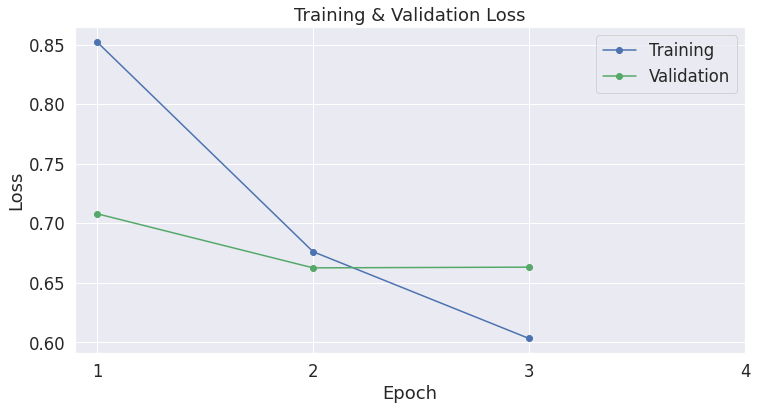

In [26]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

## 4.3. Test Multi-BERT on Arabic XNLI

In [28]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
xnli_mb_test_input_ids = []
xnli_mb_test_attention_masks = []
xnli_labels = []

# For every sentence...
for ex in xnli_ar:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer_m_bert.encode_plus(
                        ex['premise'],                      # Sentences to encode.
                        ex['hypothesis'],                      
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    xnli_mb_test_input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    xnli_mb_test_attention_masks.append(encoded_dict['attention_mask'])

    xnli_labels.append(ex['label'])

# Convert the lists into tensors.
xnli_mb_test_input_ids = torch.cat(xnli_mb_test_input_ids, dim=0)
xnli_mb_test_attention_masks = torch.cat(xnli_mb_test_attention_masks, dim=0)
xnli_labels = torch.tensor(xnli_labels)

# Set the batch size.  
batch_size = 16  

# Create the DataLoader.
xnli_mb_prediction_data = TensorDataset(xnli_mb_test_input_ids, xnli_mb_test_attention_masks, xnli_labels)
xnli_mb_prediction_sampler = SequentialSampler(xnli_mb_prediction_data)
xnli_mb_prediction_dataloader = DataLoader(xnli_mb_prediction_data, sampler=xnli_mb_prediction_sampler, batch_size=batch_size)

In [29]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(xnli_mb_test_input_ids)))

# Put model in evaluation mode
m_bert_model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in xnli_mb_prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions.
        result = m_bert_model(b_input_ids, 
                              token_type_ids=None, 
                              attention_mask=b_input_mask,
                              return_dict=True)
    
    logits = result.logits
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 5,010 test sentences...
    DONE.


In [30]:
mb_accuracies = []
for i in range(len(predictions)):
    mb_accuracies += [flat_accuracy(predictions[i], true_labels[i])]

mb_mean = sum(mb_accuracies)/len(mb_accuracies)
print('Accuracies for each test batch: ', mb_accuracies)
print('Average test accuracy: ', mb_mean)

Accuracies for each test batch:  [0.75, 0.75, 0.4375, 0.5625, 0.5, 0.5625, 0.75, 0.5625, 0.6875, 0.6875, 0.75, 0.625, 0.75, 0.625, 0.4375, 0.75, 0.8125, 0.6875, 0.3125, 0.75, 0.5, 0.5, 0.5625, 0.5625, 0.6875, 0.75, 0.6875, 0.5625, 0.3125, 0.625, 0.6875, 0.6875, 0.375, 0.375, 0.5, 0.4375, 0.4375, 0.375, 0.375, 0.4375, 0.375, 0.5625, 0.5, 0.4375, 0.75, 0.5, 0.625, 0.4375, 0.5, 0.625, 0.375, 0.5, 0.375, 0.625, 0.5, 0.625, 0.625, 0.5, 0.5, 0.5, 0.4375, 0.375, 0.625, 0.375, 0.5625, 0.4375, 0.75, 0.625, 0.5, 0.5625, 0.625, 0.5625, 0.5625, 0.6875, 0.75, 0.4375, 0.5, 0.6875, 0.5625, 0.5625, 0.5, 0.375, 0.6875, 0.5, 0.3125, 0.5, 0.6875, 0.5, 0.375, 0.625, 0.625, 0.8125, 0.5625, 0.6875, 0.6875, 0.5625, 0.4375, 0.375, 0.5, 0.5, 0.8125, 0.5625, 0.6875, 0.625, 0.5, 0.5, 0.625, 0.5625, 0.4375, 0.4375, 0.6875, 0.5625, 0.5, 0.6875, 0.625, 0.5, 0.5625, 0.5625, 0.5625, 0.4375, 0.5, 0.5625, 0.5625, 0.5625, 0.375, 0.5, 0.5625, 0.625, 0.5, 0.4375, 0.625, 0.5625, 0.625, 0.625, 0.625, 0.5, 0.625, 0.625, 0.68

In [31]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()
import os
BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/project'
output_dir = f'{BASE_PATH}/mb_mnli_model/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = m_bert_model.module if hasattr(m_bert_model, 'module') else m_bert_model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer_m_bert.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to /content/drive/MyDrive/Colab Notebooks/project/mb_mnli_model/


('/content/drive/MyDrive/Colab Notebooks/project/mb_mnli_model/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/project/mb_mnli_model/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/project/mb_mnli_model/vocab.txt',
 '/content/drive/MyDrive/Colab Notebooks/project/mb_mnli_model/added_tokens.json')

# 5. XLM-Roberta

In [33]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 18.5MB/s 


## 5.1. Train XLM-R on MNLI

In [13]:
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification

# Load the XLM-R tokenizer.
print('Loading XLM-R tokenizer...')
tokenizer_xlm = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base', do_lower_case=True)

 # Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids_xlm = []
attention_masks_xlm = []
labels = []

# For every sentence...
for ex in mnli:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer_xlm.encode_plus(
                        ex['premise'],                  # Sentences to encode.
                        ex['hypothesis'],                      
                        add_special_tokens = True,      # Add '[CLS]' and '[SEP]'
                        max_length = 128,               # Pad & truncate all sentences.
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',          # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids_xlm.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks_xlm.append(encoded_dict['attention_mask'])

    labels.append(ex['label'])

# Convert the lists into tensors.
input_ids_xlm = torch.cat(input_ids_xlm, dim=0)
attention_masks_xlm = torch.cat(attention_masks_xlm, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print(f'Original: {mnli[0]["premise"]}; {mnli[0]["hypothesis"]}')
print('Token IDs:', input_ids_xlm[0])

Loading XLM-R tokenizer...
Original: Conceptually cream skimming has two basic dimensions - product and geography.; Product and geography are what make cream skimming work. 
Token IDs: tensor([     0, 128182,     34,  25958,  24709,   7158,  58838,   1556,   6626,
         62822, 158208,     20,  12996,    136,    700,  87168,      5,      2,
             2,  73111,    136,    700,  87168,    621,   2367,   3249,  24709,
          7158,  58838,   4488,      5,      2,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,

In [14]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [15]:
# Combine the training inputs into a TensorDataset.
mnli_xlm_dataset = TensorDataset(input_ids_xlm, attention_masks_xlm, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
mnli_xlm_train_size = int(0.9 * len(mnli_xlm_dataset))
mnli_xlm_val_size = len(mnli_xlm_dataset) - mnli_xlm_train_size

# Divide the dataset by randomly selecting samples.
mnli_xlm_train_dataset, mnli_xlm_val_dataset = random_split(mnli_xlm_dataset, [mnli_xlm_train_size, mnli_xlm_val_size])

print('{:>5,} training samples'.format(mnli_xlm_train_size))
print('{:>5,} validation samples'.format(mnli_xlm_val_size))

45,000 training samples
5,000 validation samples


In [16]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
mnli_xlm_train_dataloader = DataLoader(
            mnli_xlm_train_dataset,  # The training samples.
            sampler = RandomSampler(mnli_xlm_train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
mnli_xlm_validation_dataloader = DataLoader(
            mnli_xlm_val_dataset, # The validation samples.
            sampler = SequentialSampler(mnli_xlm_val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )


In [17]:
# Load XLM-R
xlm_model = XLMRobertaForSequenceClassification.from_pretrained(
    "xlm-roberta-base", # Use the base XLM-R model, with an uncased vocab.
    num_labels = 3, # The number of output labels--3 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
xlm_model.cuda()

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

XLMRobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (La

In [18]:
from transformers import AdamW, get_linear_schedule_with_warmup

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer_xlm = AdamW(xlm_model.parameters(),
                  lr = 5e-6, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 3

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(mnli_xlm_train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer_xlm, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


In [19]:
xlm_training_stats = training_helper(xlm_model, mnli_xlm_train_dataloader, mnli_xlm_validation_dataloader, optimizer_xlm, scheduler)


======== Epoch 1 / 3 ========
Training...
  Batch    40  of  2,813.    Elapsed: 0:00:19.
  Batch    80  of  2,813.    Elapsed: 0:00:38.
  Batch   120  of  2,813.    Elapsed: 0:00:56.
  Batch   160  of  2,813.    Elapsed: 0:01:14.
  Batch   200  of  2,813.    Elapsed: 0:01:33.
  Batch   240  of  2,813.    Elapsed: 0:01:51.
  Batch   280  of  2,813.    Elapsed: 0:02:10.
  Batch   320  of  2,813.    Elapsed: 0:02:28.
  Batch   360  of  2,813.    Elapsed: 0:02:46.
  Batch   400  of  2,813.    Elapsed: 0:03:05.
  Batch   440  of  2,813.    Elapsed: 0:03:23.
  Batch   480  of  2,813.    Elapsed: 0:03:41.
  Batch   520  of  2,813.    Elapsed: 0:04:00.
  Batch   560  of  2,813.    Elapsed: 0:04:18.
  Batch   600  of  2,813.    Elapsed: 0:04:37.
  Batch   640  of  2,813.    Elapsed: 0:04:55.
  Batch   680  of  2,813.    Elapsed: 0:05:13.
  Batch   720  of  2,813.    Elapsed: 0:05:32.
  Batch   760  of  2,813.    Elapsed: 0:05:50.
  Batch   800  of  2,813.    Elapsed: 0:06:08.
  Batch   840  of

## 5.2. Visualize XLM Training Stats

In [20]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=xlm_training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.84,0.63,0.74,0:21:32,0:00:40
2,0.62,0.58,0.77,0:21:29,0:00:40
3,0.55,0.58,0.78,0:21:29,0:00:40


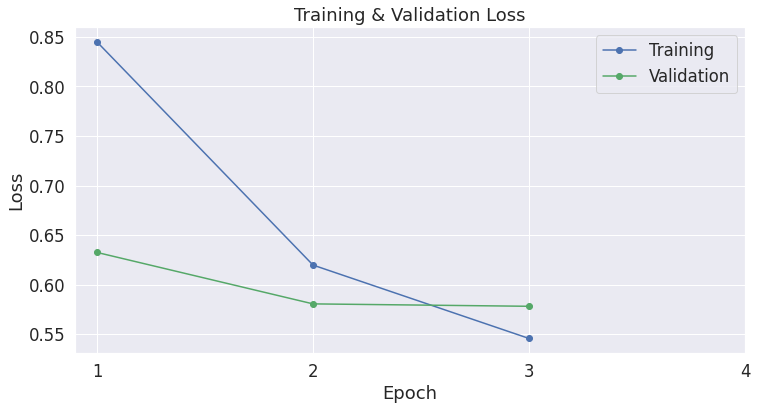

In [21]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

## 5.2. Test XLM-R on XNLI

In [22]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
xnli_xlm_test_input_ids = []
xnli_xlm_test_attention_masks = []
xnli_labels = []

# For every sentence...
for ex in xnli_ar:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer_xlm.encode_plus(
                        ex['premise'],                      # Sentences to encode.
                        ex['hypothesis'],                      
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    xnli_xlm_test_input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    xnli_xlm_test_attention_masks.append(encoded_dict['attention_mask'])

    xnli_labels.append(ex['label'])

# Convert the lists into tensors.
xnli_xlm_test_input_ids = torch.cat(xnli_xlm_test_input_ids, dim=0)
xnli_xlm_test_attention_masks = torch.cat(xnli_xlm_test_attention_masks, dim=0)
xnli_labels = torch.tensor(xnli_labels)

# Set the batch size.  
batch_size = 16  

# Create the DataLoader.
xnli_xlm_prediction_data = TensorDataset(xnli_xlm_test_input_ids, xnli_xlm_test_attention_masks, xnli_labels)
xnli_xlm_prediction_sampler = SequentialSampler(xnli_xlm_prediction_data)
xnli_xlm_prediction_dataloader = DataLoader(xnli_xlm_prediction_data, sampler=xnli_xlm_prediction_sampler, batch_size=batch_size)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [23]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(xnli_xlm_test_input_ids)))

# Put model in evaluation mode
xlm_model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in xnli_xlm_prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions.
        result = xlm_model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           return_dict=True)
        
    logits = result.logits
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 5,010 test sentences...
    DONE.


In [24]:
xlm_accuracies = []
for i in range(len(predictions)):
    xlm_accuracies += [flat_accuracy(predictions[i], true_labels[i])]

xlm_mean = sum(xlm_accuracies)/len(xlm_accuracies)
print('Accuracies for each test batch: ', xlm_accuracies)
print('Average test accuracy: ', xlm_mean)

Accuracies for each test batch:  [0.4375, 0.8125, 0.6875, 0.5, 0.5625, 0.5625, 0.75, 0.6875, 0.75, 0.875, 0.625, 0.6875, 0.6875, 0.6875, 0.5, 0.6875, 0.6875, 0.5625, 0.75, 0.6875, 0.5, 0.5625, 0.5625, 0.75, 1.0, 0.875, 0.6875, 0.6875, 0.625, 0.875, 0.6875, 0.75, 0.8125, 0.6875, 0.75, 0.5, 0.625, 0.625, 0.5, 0.5625, 0.5625, 0.5, 0.75, 0.8125, 0.75, 0.625, 0.8125, 0.6875, 0.5625, 0.5625, 0.6875, 0.6875, 0.6875, 0.8125, 0.5625, 0.875, 0.875, 0.75, 0.375, 0.6875, 0.5, 0.5625, 0.6875, 0.5625, 0.6875, 0.75, 0.75, 0.5, 0.5625, 0.5625, 0.8125, 0.625, 0.5625, 0.625, 0.625, 0.625, 0.5625, 0.6875, 0.6875, 0.875, 0.6875, 0.5625, 0.5625, 0.5625, 0.5625, 0.5625, 0.5625, 0.6875, 0.625, 0.75, 0.625, 0.9375, 0.4375, 0.6875, 0.8125, 0.6875, 0.4375, 0.375, 0.75, 0.5625, 0.5, 0.75, 0.625, 0.6875, 0.5625, 0.5, 0.5, 0.75, 0.5, 0.625, 0.8125, 0.75, 0.5, 0.6875, 0.5, 0.625, 0.625, 0.8125, 0.5625, 0.6875, 0.6875, 0.6875, 0.5, 0.5625, 0.625, 0.75, 0.5, 0.6875, 0.6875, 0.625, 0.625, 0.625, 0.6875, 0.625, 0.5625,

In [25]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()
import os
BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/project'
output_dir = f'{BASE_PATH}/xlm_mnli_model/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = xlm_model.module if hasattr(xlm_model, 'module') else xlm_model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer_xlm.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to /content/drive/MyDrive/Colab Notebooks/project/xlm_mnli_model/


('/content/drive/MyDrive/Colab Notebooks/project/xlm_mnli_model/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/project/xlm_mnli_model/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/project/xlm_mnli_model/sentencepiece.bpe.model',
 '/content/drive/MyDrive/Colab Notebooks/project/xlm_mnli_model/added_tokens.json')

# 6. Conclusion

Based on the results of fine-tuning and testing the two models - Multi-BERT and XLM-Roberta - on the NLI task, it is clear that XLM-R is the better multilingual model for zero-shot cross-lingual tasks. Multi-BERT had an average test accuracy of 0.5686703821656051 (or about 56.8%) and XLM-R had an average test accuracy of 0.6648089171974523 (or about 66.5%) which is nearly a 10 percentage-point increase.